#**AI VIET NAM**
#**Transformer Applications**

#**Transformer**

In [2]:
!pip install torchtext

  Using cached torch-2.2.2-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl.m

In [1]:
import torchtext
import torch
import torch.nn as nn
from torch.nn import functional as F

###**Transformer-Encoder**

####**Token and Positional Embedding**

In [2]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

####**Transformer-Encoder Block**

In [3]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

####**Transformer-Encoder**

In [4]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 src_vocal_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'
                 ):
      super().__init__()
      self.embedding = TokenAndPositionEmbedding(
          src_vocal_size, embed_dim, max_length, device
      )
      self.layers = nn.ModuleList(
          [
              TransformerEncoderBlock(
                  embed_dim, num_heads, ff_dim, dropout
              ) for i in range(num_layers)
          ]
      )

    def forward(self, x):
      output = self.embedding(x)
      for layer in self.layers:
        output = layer(output, output, output)
      return output

In [5]:
batch_size = 32
src_vocab_size = 1000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [6]:
input = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [7]:
encoder = TransformerEncoder(
    src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
)

In [8]:
encoded = encoder(input)

In [9]:
encoded.shape

torch.Size([32, 100, 200])

###**Transformer-Decoder**

####**Transformer Decoder Block**

In [10]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_3 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.dropout_3 = nn.Dropout(p=dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output, _ = self.attn(x, x, x, attn_mask=tgt_mask)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(x + attn_output)

        attn_output, _ = self.cross_attn(
            out_1, enc_output, enc_output, attn_mask=src_mask
        )
        attn_output = self.dropout_2(attn_output)
        out_2 = self.layernorm_2(out_1 + attn_output)

        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout_2(ffn_output)
        out_3 = self.layernorm_2(out_2 + ffn_output)
        return out_3

####**Transformer-Decoder**

In [11]:
class TransformerDecoder(nn.Module):
    def __init__(self,
                 tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'
                 ):
      super().__init__()
      self.embedding = TokenAndPositionEmbedding(
          tgt_vocab_size, embed_dim, max_length, device
      )
      self.layers = nn.ModuleList(
          [
              TransformerDecoderBlock(
                  embed_dim, num_heads, ff_dim, dropout
              ) for i in range(num_layers)
          ]
      )

    def forward(self, x, enc_output, src_mask, tgt_mask):
      output = self.embedding(x)
      for layer in self.layers:
        output = layer(output, enc_output, src_mask, tgt_mask)
      return output

###**Transformer**

In [12]:
class Transformer(nn.Module):
    def __init__(self,
                 src_vocal_size, tgt_vocab_size,
                 embed_dim, max_length, num_layers, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
                 ):
      super().__init__()
      self.device = device
      self.encoder = TransformerEncoder(
          src_vocal_size, embed_dim, max_length, num_layers, num_heads, ff_dim
      )
      self.decoder = TransformerDecoder(
          tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
      )
      self.fc = nn.Linear(embed_dim, tgt_vocab_size)

    def generate_mask(self, src, tgt):
      src_seq_len = src.shape[1]
      tgt_seq_len = tgt.shape[1]

      src_mask = torch.zeros(
          (tgt_seq_len, src_seq_len),
          device=self.device).type(torch.bool)

      tgt_mask = (torch.triu(torch.ones(
          (tgt_seq_len, tgt_seq_len),
          device=self.device)
      ) == 1).transpose(0, 1)
      tgt_mask = tgt_mask.float().masked_fill(
          tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))
      return src_mask, tgt_mask

    def forward(self, src, tgt):
      src_mask, tgt_mask = self.generate_mask(src, tgt)
      enc_output = self.encoder(src)
      dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
      output = self.fc(dec_output)
      return output

In [13]:
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

In [14]:
model = Transformer(
    src_vocab_size, tgt_vocab_size,
    embed_dim, max_length, num_layers, num_heads, ff_dim
)

In [15]:
src = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [16]:
src

tensor([[1, 0, 1,  ..., 1, 1, 0],
        [1, 0, 1,  ..., 0, 1, 1],
        [0, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 1],
        [0, 1, 1,  ..., 1, 0, 1]])

In [17]:
tgt = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [18]:
prediction = model(src, tgt)

In [19]:
prediction.shape

torch.Size([128, 100, 2000])

#**Text Classification using Transformer-Encoder**

###**Load Dataset**

In [20]:
!pip install datasets

In [21]:
from datasets import load_dataset

ds = load_dataset('thainq107/ntc-scv')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [22]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
})

###**Preprocessing**

**Text Cleaning**

In [23]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

###**Representation**

In [24]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [25]:
# word-based tokenizer
import torchtext
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [26]:
ds['train']['preprocessed_sentence'][0]

'cửa hàng nhỏ xinh trên mặt đường vị trí khá dễ tìm đồ ăn ngon giá phải chăng bánh mỳ chảo cười bánh mỳ sốt vang và xúc xích cùng sữa ngô nữa hết có k qúa ổn luôn'

In [27]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(ds['train']['preprocessed_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [28]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for row in df:
        sentence = row['preprocessed_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(ds['train'])
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(ds['valid'])
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(ds['test'])
test_dataset = to_map_style_dataset(test_dataset)

In [29]:
for row in ds['train']:
    print(vocabulary(tokenizer(row['preprocessed_sentence'])))
    break

[351, 111, 112, 529, 124, 228, 196, 53, 159, 43, 103, 256, 46, 2, 11, 31, 52, 723, 32, 491, 991, 533, 32, 491, 220, 1415, 9, 731, 897, 185, 130, 836, 57, 88, 4, 14, 3183, 251, 59]


###**Dataloader**

In [30]:
import torch

seq_length = 100

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [31]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [32]:
next(iter(train_dataloader))

(tensor([[   7,  445,   94,  ...,    0,    0,    0],
         [ 107, 3609,  155,  ...,    0,    0,    0],
         [  63,  636,   92,  ...,    0,    0,    0],
         ...,
         [   3,    2,    7,  ...,  465,    7,   43],
         [   3,   58, 3813,  ...,    0,    0,    0],
         [  20,    5,   41,  ...,    0,    0,    0]]),
 tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
         1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
         0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
         1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
         1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
         1, 0, 0, 0, 1, 1, 1, 1]))

In [33]:
len(train_dataloader)

235

In [34]:
encoded_sentences, labels = next(iter(train_dataloader))

In [35]:
encoded_sentences.shape

torch.Size([128, 100])

In [36]:
labels.shape

torch.Size([128])

###**Trainer**

In [37]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [38]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [39]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt', weights_only=True))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [40]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

###**Modeling**

In [41]:
class TransformerEncoderCls(nn.Module):
    def __init__(self,
                 vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
                 ):
      super().__init__()
      self.encoder = TransformerEncoder(
          vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
      )
      self.pooling = nn.AvgPool1d(kernel_size=max_length)
      self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
      self.fc2 = nn.Linear(in_features=20, out_features=2)
      self.dropout = nn.Dropout(p=dropout)
      self.relu = nn.ReLU()

    def forward(self, x):
      output = self.encoder(x)
      output = self.pooling(output.permute(0, 2, 1)).squeeze()
      output = self.dropout(output)
      output = self.fc1(output)
      output = self.dropout(output)
      output = self.fc2(output)
      return output

In [42]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout=0.1

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

In [43]:
encoded_sentences.shape

torch.Size([128, 100])

In [44]:
predictions = model(encoded_sentences)

In [45]:
predictions.shape

torch.Size([128, 2])

In [46]:
predictions

tensor([[-0.3750,  0.1756],
        [-0.3814,  0.1370],
        [-0.1829,  0.3201],
        [-0.2758,  0.2959],
        [-0.2556,  0.1297],
        [-0.1205,  0.2423],
        [-0.1282,  0.4158],
        [-0.2678,  0.2243],
        [-0.2300,  0.4493],
        [-0.4526,  0.2727],
        [-0.0657,  0.3307],
        [-0.1944,  0.2746],
        [-0.2793,  0.0614],
        [-0.0654,  0.2667],
        [-0.3068,  0.0799],
        [-0.3681,  0.1867],
        [-0.2685,  0.1478],
        [-0.1254,  0.2092],
        [-0.2549,  0.0911],
        [-0.2603,  0.4117],
        [-0.3375,  0.0778],
        [-0.3864,  0.2530],
        [-0.0278,  0.2677],
        [-0.0153,  0.1644],
        [-0.2849,  0.2088],
        [-0.4071,  0.3003],
        [-0.4274, -0.0029],
        [-0.0888,  0.2389],
        [-0.1715,  0.2258],
        [-0.2496,  0.3396],
        [-0.0877,  0.2640],
        [-0.3441,  0.2375],
        [-0.1052,  0.2342],
        [-0.3607,  0.2206],
        [-0.2467,  0.3019],
        [-0.2457,  0

###**Training**

In [47]:
import os
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  235 batches | accuracy    0.522
| epoch   1 |   100/  235 batches | accuracy    0.565
| epoch   1 |   150/  235 batches | accuracy    0.631
| epoch   1 |   200/  235 batches | accuracy    0.695
-----------------------------------------------------------
| End of epoch   1 | Time: 10.76s | Train Accuracy    0.741 | Train Loss    0.652 | Valid Accuracy    0.759 | Valid Loss    0.543 
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.767
| epoch   2 |   100/  235 batches | accuracy    0.789
| epoch   2 |   150/  235 batches | accuracy    0.790
| epoch   2 |   200/  235 batches | accuracy    0.795
-----------------------------------------------------------
| End of epoch   2 | Time:  8.58s | Train Accuracy    0.803 | Train Loss    0.470 | Valid Accuracy    0.801 | Valid Loss    0.447 
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.811
| epoch   3 

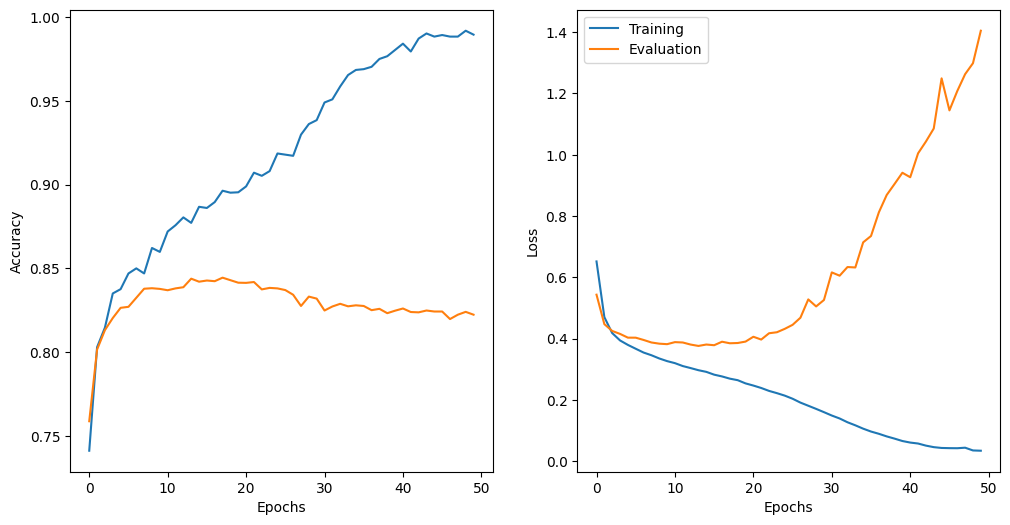

In [48]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [49]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8258, 1.2829320932490915)

#**Text Classification using BERT**

In [1]:
!pip install -q datasets accelerate evaluate

###**Load Dataset**

In [2]:
from datasets import load_dataset

ds = load_dataset('thainq107/ntc-scv')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence'],
        num_rows: 10000
    })
})

###**Preprocessing**

In [4]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True
)

In [5]:
tokenizer.model_max_length

512

In [6]:
max_seq_length = 100
max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
    # Tokenize the texts

    result = tokenizer(
        examples["preprocessed_sentence"],
        padding="max_length",
        max_length=max_seq_length,
        truncation=True
    )
    result["label"] = examples['label']

    return result

In [7]:
# Running the preprocessing pipeline on all the datasets
processed_dataset = ds.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)

In [8]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
    valid: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['sentence', 'label', 'preprocessed_sentence', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
})

###**Modeling**

In [9]:
from transformers import AutoConfig, AutoModelForSequenceClassification

num_labels = 2

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task='text-classification'
)


In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


###**Metric**

In [12]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

###**Trainer**

In [13]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='ntc-scv-distilbert-base-uncased',
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-1d8e69985dd1>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


###**Training**

In [14]:
import wandb
wandb.init(mode='disabled')

In [15]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.455104,0.791300
2,No log,0.411303,0.815000
3,No log,0.414708,0.819600
4,No log,0.399896,0.832000
5,0.418700,0.397899,0.837600
6,0.418700,0.398217,0.836200
7,0.418700,0.408802,0.836800
8,0.418700,0.411609,0.838900
9,0.293600,0.418198,0.839800
10,0.293600,0.420039,0.840200


TrainOutput(global_step=1180, training_loss=0.3403726610086732, metrics={'train_runtime': 2566.057, 'train_samples_per_second': 116.911, 'train_steps_per_second': 0.46, 'total_flos': 7761761640000000.0, 'train_loss': 0.3403726610086732, 'epoch': 10.0})

In [16]:
trainer.evaluate(processed_dataset["test"])

{'eval_loss': 0.37534472346305847,
 'eval_accuracy': 0.8446,
 'eval_runtime': 24.7723,
 'eval_samples_per_second': 403.676,
 'eval_steps_per_second': 1.615,
 'epoch': 10.0}

In [17]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="thainq107/ntc-scv-distilbert-base-uncased"
)

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [18]:
classifier("quán ăn này ngon quá luôn nè")

[{'label': 'LABEL_1', 'score': 0.78251713514328}]